In [1]:
# # !pip install wordcloud
# import nltk
# nltk.download('stopwords')

#### Importing necesarry libraries

In [2]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Reading and checking data

In [3]:
df=pd.read_csv('Emotion_classify_Data.csv')
print(df.shape)
df.head()

(5937, 2)


,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


#### Basic EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [5]:
df.isna().sum()

Comment    0
Emotion    0
dtype: int64

In [6]:
df.duplicated().sum()

0

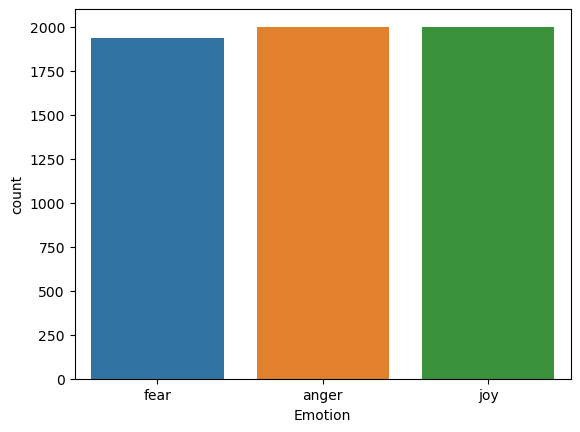

In [7]:
sns.countplot(x=df.Emotion)
plt.show()

#### Defining and applying Preprocess function

In [8]:
# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

#use this utility function to get the preprocessed text data
def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [9]:
df['comment_preprocessed']=df['Comment'].apply(preprocess)

In [10]:
all_words = ' '.join(word for word in df['comment_preprocessed']) 

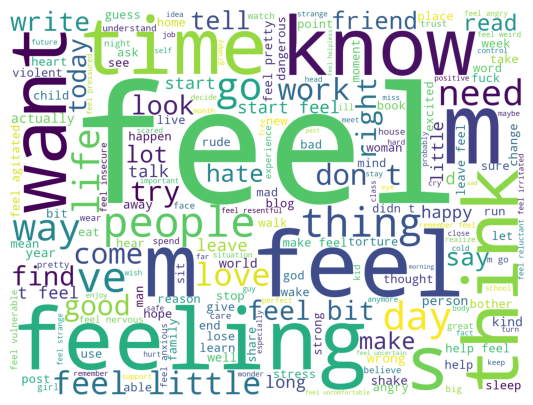

In [11]:
wc = WordCloud(
    height =1500,
    width = 2000,
    background_color = 'white').generate(all_words)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

#### Training Models

In [12]:
tfidf=TfidfVectorizer()
x=tfidf.fit_transform(df['comment_preprocessed'])

In [13]:
le=LabelEncoder()
df['Emotion_encoded']=le.fit_transform(df['Emotion'])

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,df['Emotion_encoded'],test_size=0.2,random_state=42,stratify=df['Emotion_encoded'])

In [15]:
NB_model=MultinomialNB()
NB_model.fit(x_train,y_train)

MultinomialNB()

In [31]:
y_pred=NB_model.predict(x_test)
print(f'Classification report of MultinomialNB:\n{classification_report(y_test,y_pred)}')

Classification report of MultinomialNB:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       400
           1       0.88      0.90      0.89       388
           2       0.92      0.89      0.91       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



In [17]:
RF_model=RandomForestClassifier()
RF_model.fit(x_train,y_train)

RandomForestClassifier()

In [32]:
y_pred=RF_model.predict(x_test)
print(f'Classification report of Random Forest:\n{classification_report(y_test,y_pred)}')

Classification report of Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       400
           1       0.94      0.92      0.93       388
           2       0.91      0.95      0.93       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



## Integrating TF-IDF and Random Forest to a Pipeline

In [19]:
X_train,X_test,Y_train,Y_test=train_test_split(df['comment_preprocessed'],df['Emotion_encoded'],random_state=42,test_size=0.2,
                                               stratify=df['Emotion_encoded'])

In [20]:
rfp=Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('randomForest',RandomForestClassifier())
])
rfp.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('randomForest', RandomForestClassifier())])

In [21]:
Y_pred=rfp.predict(X_test)

In [22]:
def evaluation(y_test,y_pred):
    print('Classification report for random forest:\n')
    print(classification_report(y_test,y_pred))
    cm=confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()

Classification report for random forest:

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       400
           1       0.93      0.93      0.93       388
           2       0.92      0.94      0.93       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



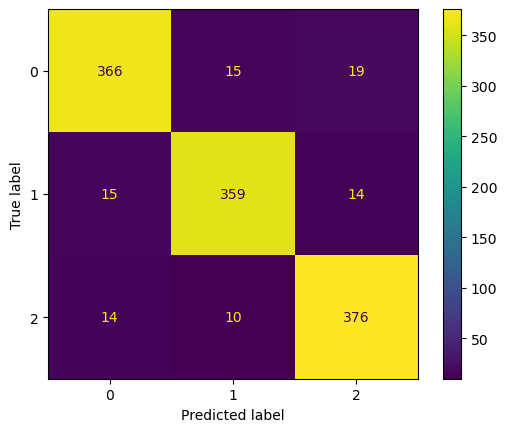

In [23]:
evaluation(Y_test,Y_pred)

In [24]:
def emotion_check(text):
    preprocessed_text=preprocess(text)
    emotion_pred=rfp.predict([preprocessed_text])
    emotion_pred=le.inverse_transform(emotion_pred)
    return emotion_pred[0]

In [25]:
sample_text=input('Enter sample comment:')
print(f'Predicted Emotion: {emotion_check(sample_text)}')

Enter sample comment: i am very scared of hight


Predicted Emotion: fear


In [26]:
# import joblib

# # Save the pipeline model
# model_filename = 'emotion_classification_pipeline.pkl'
# joblib.dump(rfp, model_filename)

# # Save the label encoder
# label_encoder_filename = 'label_encoder.pkl'
# joblib.dump(le, label_encoder_filename)

# print(f"Pipeline model saved as {model_filename}")
# print(f"Label encoder saved as {label_encoder_filename}")
